# 25-7. 프로젝트: Spectrogram classification 모델 구현

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random
import librosa.display
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers


## 1. 데이터 처리와 분류

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  34935
Wave data shape :  (8000,)
label :  ['right']


In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print("✅")

✅


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print("✅")

✅


In [7]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [8]:
raw_data = []
    
for wav in speech_data["wav_vals"]:
    raw_data.append(wav2spec(wav))

raw_data = np.array(raw_data)

In [9]:
print(raw_data.shape)

(50620, 130, 126)


In [10]:
# 죽는 부분
# from sklearn.model_selection import train_test_split


# train_wav, test_wav, train_label, test_label = train_test_split(raw_data, 
#                                                                 label_data, 
#                                                                 test_size=0.1,
#                                                                 shuffle=True)
# print(train_wav)
# print("✅")

In [18]:
from sklearn.model_selection import train_test_split


train_wav, test_wav, train_label, test_label = train_test_split(raw_data[0:20000], 
                                                                label_data[0:20000], 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)
print("✅")

[[[6.83146864e-05 6.00144085e-05 4.27011582e-05 ... 2.01308215e-03
   3.04752699e-04 1.73602358e-03]
  [5.17342451e-05 2.01562816e-05 2.98622890e-05 ... 1.26018645e-02
   1.12719964e-02 9.35059786e-03]
  [3.32991876e-05 2.98407194e-05 3.08357121e-05 ... 3.29295509e-02
   2.05136444e-02 1.60937980e-02]
  ...
  [4.55187273e-06 2.56926819e-06 3.18040151e-07 ... 8.30434074e-05
   9.35338845e-04 1.76868157e-03]
  [3.74360729e-06 1.81109021e-06 9.74309700e-08 ... 3.94513554e-05
   9.70449415e-04 1.83222070e-03]
  [3.16101637e-06 1.48222762e-06 1.67820787e-07 ... 7.16583872e-06
   9.39180201e-04 1.84665073e-03]]

 [[3.19010898e-04 1.04470986e-04 8.01857095e-04 ... 1.31358785e-04
   3.47753055e-04 9.65622312e-04]
  [1.11926685e-03 9.41080216e-04 1.41288957e-03 ... 5.37881337e-04
   7.06537976e-04 7.80101807e-04]
  [1.81532127e-03 1.58049550e-03 1.34308706e-03 ... 7.99411850e-04
   8.33392085e-04 5.16411274e-05]
  ...
  [6.35450488e-05 3.22925880e-05 3.35118966e-06 ... 8.71852717e-06
   1.10131

In [19]:
sr = (130, 126)

train_wav_1d = train_wav.reshape([-1, 130, 126, 1]) # add channel for CNN
test_wav_1d = test_wav.reshape([-1, 130, 126, 1])

In [20]:
print("train data : ", train_wav.shape)
print("train data : ", train_wav_1d.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test data : ", test_wav_1d.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (18000, 130, 126)
train data :  (18000, 130, 126, 1)
train labels :  (18000,)
test data :  (2000, 130, 126)
test data :  (2000, 130, 126, 1)
test labels :  (2000,)
✅


## 2. 학습을 위한 하이퍼파라미터 설정

In [21]:
batch_size = 5
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel0042/aiffel/speech_recognition/models/wav'

## 3. 데이터셋 구성

In [22]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [23]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [24]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 31, 64)        0     

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [27]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
3596/3600 [============================>.] - ETA: 0s - loss: 0.9853 - accuracy: 0.6722
Epoch 00001: val_loss improved from inf to 0.28456, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
3600/3600 [==============================] - 39s 11ms/step - loss: 0.9847 - accuracy: 0.6724 - val_loss: 0.2846 - val_accuracy: 0.9025
Epoch 2/10
3599/3600 [============================>.] - ETA: 0s - loss: 0.3869 - accuracy: 0.8813
Epoch 00002: val_loss improved from 0.28456 to 0.22675, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
3600/3600 [==============================] - 37s 10ms/step - loss: 0.3869 - accuracy: 0.8813 - val_loss: 0.2267 - val_accuracy: 0.9265
Epoch 3/10
3600/3600 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9289
Epoch 00003: val_loss improved from 0.22675 to 0.19213, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
3600/3600 [==============================] - 37s 10ms/step - l

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

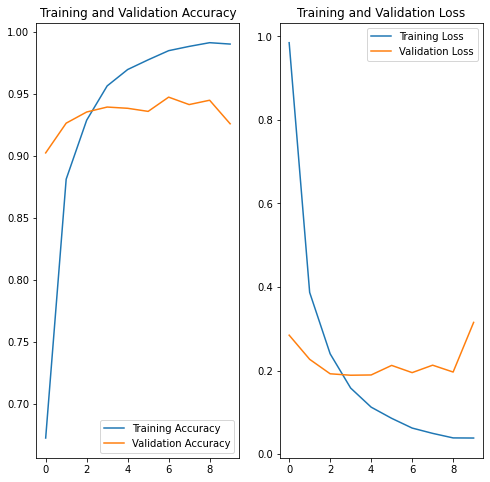

✅


In [28]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가

In [29]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [30]:
results = model_wav.evaluate(test_dataset)
print("✅")

400/400 [==============================] - 1s 3ms/step - loss: 0.1887 - accuracy: 0.9395
✅


In [31]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.189
accuracy value: 93.9500%
✅


In [32]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

# ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  go


In [33]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: up
✅


틀렸다!!

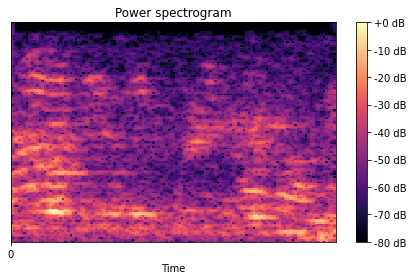

In [34]:
librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 7. Skip-Connection model

In [35]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 130, 126, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [36]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [37]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [38]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
3597/3600 [============================>.] - ETA: 0s - loss: 1.0125 - accuracy: 0.6646
Epoch 00001: val_loss improved from inf to 0.33361, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
3600/3600 [==============================] - 38s 11ms/step - loss: 1.0120 - accuracy: 0.6648 - val_loss: 0.3336 - val_accuracy: 0.8920
Epoch 2/10
3600/3600 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.8751
Epoch 00002: val_loss improved from 0.33361 to 0.22524, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
3600/3600 [==============================] - 38s 11ms/step - loss: 0.4090 - accuracy: 0.8751 - val_loss: 0.2252 - val_accuracy: 0.9260
Epoch 3/10
3599/3600 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.9266
Epoch 00003: val_loss improved from 0.22524 to 0.21330, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
3600/3600 [==============================] - 38

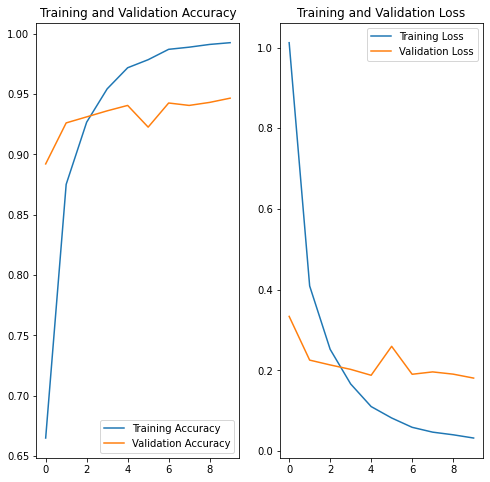

✅


In [39]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [40]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

400/400 [==============================] - 1s 4ms/step - loss: 0.1807 - accuracy: 0.9465
loss value: 0.181
accuracy value: 94.6500%
✅


In [41]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  off


In [42]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: off
✅


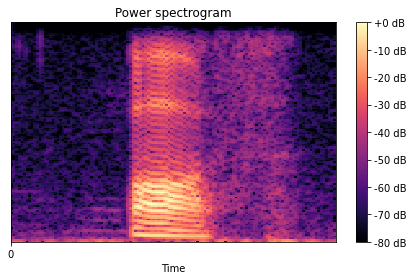

In [43]:
librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 8. 총평

전체 데이터셋을 활용하자 OOM문제가 발생하였다. 하여, 전체 데이터 중 3만개만 활용하여 학습해주었다.
해당 문제의 원인은 파악하지 못하였다.